# Лабораторная работа 331: Исследование фотоэлементов


In [17]:
import matplotlib.pyplot as polt
import numpy as np
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from rich.console import Console
from rich.table import Table
from scipy import stats
from sympy import Eq, solve, symbols


console = Console()

In [18]:
h = 6.63 * 10 ** (-34)  # постоянная Планка
c = 3 * 10**8  # скорость света
k = 1.38 * 10 ** (-23)  # постоянная Больцмана

l_cap = 0.5  # ширина щели в колпаке (сантиметра)
T = 2880  # температура лампы (K)

In [19]:
# Название фотоэлементов
SCV = "СЦВ-4"  # вакуум
CG = "ЦГ-4"  # газ

In [20]:
experiment_VAC_data: dict[str, dict[str, np.ndarray]] = {
  SCV: {
    # Вольт
    "U": np.array(
      [
        0.109,
        10.215,
        20.09,
        35.18,
        50.15,
        65.11,
        80.15,
        95.11,
        110.19,
        125.04,
        140.31,
        155.24,
        170.22,
        185.17,
        200.35,
        209.95,
        # тут в обратную пошли
        200.41,
        190.29,
        175.14,
        160.34,
        145.08,
        130.26,
        115.3,
        100,
        85.3,
        70.04,
        55.03,
        40.79,
        25.24,
        10.25,
        0.013,
      ]
    ),
    # микро Ампер
    "I": np.array(
      [
        0.09,
        2.6,
        4.15,
        5.77,
        6.91,
        8.15,
        9.01,
        9.04,
        9.07,
        9.09,
        9.10,
        9.12,
        9.14,
        9.16,
        9.18,
        9.19,
        # тут в обратную пошли
        9.19,
        9.18,
        9.17,
        9.15,
        9.14,
        9.13,
        9.11,
        9.09,
        9.07,
        8.86,
        7.29,
        6.36,
        4.92,
        2.82,
        0.05,
      ]
    ),
  },
  CG: {  # Вольт
    "U": np.array(
      [
        0.0011,
        15,
        30.07,
        45,
        60.13,
        75.06,
        90.09,
        105.03,
        120.17,
        135.11,
        150.17,
        165.42,
        180.16,
        190.21,
        200.04,
        # тут в обратную пошли
        185.07,
        170.05,
        155,
        140.16,
        125.18,
        110.22,
        95.07,
        80,
        65.05,
        50.56,
        35.07,
        20.21,
        10.1,
        0.0021,
      ]
    ),
    # микро Ампер
    "I": np.array(
      [
        0.011,
        1.14,
        1.43,
        2.07,
        2.6,
        3.11,
        3.66,
        4.24,
        4.83,
        5.44,
        6.06,
        6.72,
        7.4,
        7.92,
        8.42,
        # тут в обратную пошли
        7.79,
        7.15,
        6.51,
        5.87,
        5.23,
        4.6,
        3.96,
        3.36,
        2.8,
        2.29,
        1.71,
        1.19,
        0.99,
        0,
      ]
    ),
  },
}

centimeters = np.concatenate([np.arange(0, 23), np.arange(21.5, -0.5, -1), [0]])

experiment_spectral_data: dict[str, dict[str, np.ndarray]] = {
  SCV: {
    # Сантиметр
    "l": centimeters,
    # микро Ампер
    "I": np.array(
      [
        0.773,
        0.593,
        0.398,
        0.284,
        0.222,
        0.18,
        0.165,
        0.138,
        0.125,
        0.129,
        0.119,
        0.106,
        0.118,
        0.122,
        0.103,
        0.114,
        0.119,
        0.101,
        0.112,
        0.101,
        0.1,
        0.103,
        0.098,
        # тут в обратную пошли
        0.099,
        0.118,
        0.107,
        0.105,
        0.121,
        0.108,
        0.107,
        0.127,
        0.111,
        0.113,
        0.133,
        0.118,
        0.122,
        0.127,
        0.135,
        0.15,
        0.171,
        0.203,
        0.26,
        0.351,
        0.492,
        0.7,
        0.788,
      ]
    ),
  },
  CG: {  # Сантиметр
    "l": centimeters,
    # микро Ампер
    "I": np.array(
      [
        0.119,
        0.121,
        0.126,
        0.15,
        0.178,
        0.226,
        0.26,
        0.3,
        0.325,
        0.344,
        0.319,
        0.304,
        0.294,
        0.256,
        0.243,
        0.214,
        0.196,
        0.191,
        0.172,
        0.156,
        0.145,
        0.139,
        0.129,
        # тут в обратную пошли
        0.135,
        0.142,
        0.155,
        0.168,
        0.181,
        0.21,
        0.213,
        0.23,
        0.25,
        0.275,
        0.298,
        0.322,
        0.333,
        0.335,
        0.319,
        0.279,
        0.24,
        0.2,
        0.163,
        0.141,
        0.13,
        0.134,
        0.119,
      ]
    ),
  },
}


In [21]:
# Assert data
for data in (experiment_VAC_data, experiment_spectral_data):
  for key in data:
    keys = list(data[key].keys())
    for i in range(len(keys) - 1):
      assert len(data[key][keys[i]]) == len(data[key][keys[i + 1]])
      print(
        f'len(data["{key}"]["{keys[i]}"]) == len(data["{key}"]["{keys[i + 1]}"])'
        f' == "{len(data[key][keys[i]])}"'
      )

len(data["СЦВ-4"]["U"]) == len(data["СЦВ-4"]["I"]) == "31"
len(data["ЦГ-4"]["U"]) == len(data["ЦГ-4"]["I"]) == "29"
len(data["СЦВ-4"]["l"]) == len(data["СЦВ-4"]["I"]) == "46"
len(data["ЦГ-4"]["l"]) == len(data["ЦГ-4"]["I"]) == "46"


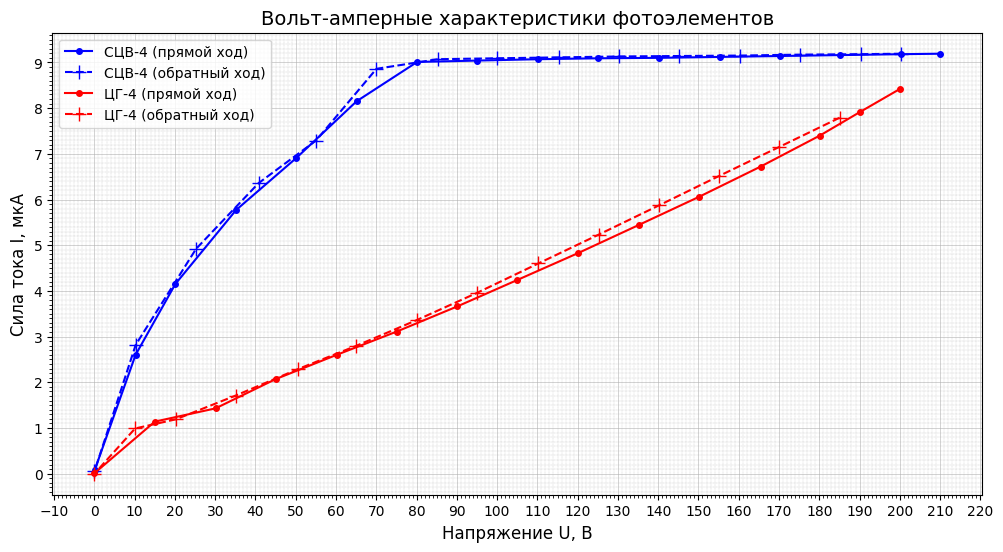

In [22]:
_, ax = polt.subplots(1, 1, figsize=(12, 6))

ax.set_title("Вольт-амперные характеристики фотоэлементов", fontsize=14)
ax.set_xlabel("Напряжение U, В", fontsize=12)
ax.set_ylabel("Сила тока I, мкА", fontsize=12)

# Цвета для разных фотоэлементов
colors = {SCV: "blue", CG: "red"}

# Построение графиков для каждого фотоэлемента
for element_name, data in experiment_VAC_data.items():
  U = data["U"]
  I = data["I"]

  # Определяем точки разворота (где начинаются обратные ходы)
  if element_name == SCV:
    forward_end = 16  # первые 16 точек - прямой ход
    backward_start = 16  # остальные - обратный
  else:  # CG
    forward_end = 15  # первые 15 точек - прямой ход
    backward_start = 15  # остальные - обратный

  # Разделяем данные на прямой и обратный ход
  U_forward = U[:forward_end]
  I_forward = I[:forward_end]
  U_backward = U[backward_start:]
  I_backward = I[backward_start:]

  # Строим графики
  ax.plot(
    U_forward,
    I_forward,
    marker="o",
    # s=10,
    markersize=4,
    linestyle="-",
    linewidth=1.5,
    color=colors[element_name],
    label=f"{element_name} (прямой ход)",
  )

  ax.plot(
    U_backward,
    I_backward,
    marker="+",
    # s=50,
    markersize=10,
    linestyle="--",
    linewidth=1.5,
    color=colors[element_name],
    label=f"{element_name} (обратный ход)",
  )

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

polt.grid(which="minor", linestyle="--", linewidth=0.2)
polt.grid(which="major", linewidth=0.4)

polt.legend()
polt.show()

**Связь шкалы монохроматора и длины волны (аппроксимация):**
Для пересчета координаты $x$ на шкале монохроматора в длину волны $\lambda$ используется эмпирическая формула, следующая из формулы Коши.

$$
x(\lambda) = A + \frac{B}{\lambda^2} \quad \text{или} \quad \lambda(x) = \sqrt{\frac{B}{x - A}}
$$

**Расчет ширины спектрального интервала $\Delta \lambda$:**
Ширина спектрального интервала, попадающего на фотоэлемент, определяется из градуировочной зависимости $\lambda(x)$.

$$
\Delta \lambda = \frac{d\lambda}{dx} \Delta x
$$

где $\Delta x$ — ширина щели на фотоэлементе. Производная вычисляется из аппроксимационной формулы:

$$
\frac{d\lambda}{dx} = -\frac{1}{2} \frac{\lambda(x)}{x - A}
$$


In [23]:
A, B = symbols("a b")

eq_1 = Eq((7 * 10**3) ** 2, B / (1 - A))
eq_2 = Eq((4.8 * 10**3) ** 2, B / (19 - A))

solution = solve((eq_1, eq_2), (A, B))
console.print(f"A = {solution[A]}, B = {solution[B]}")

A = float(solution[A])
B = float(solution[B])

A = -14.9753466872111, B = 782791987.673344

Решение системы уравнений:

$$
\begin{cases}
A = -\dfrac{9719}{649} \\[2ex]
B = \dfrac{508032000000}{649}
\end{cases}
$$


In [24]:
def l_to_lambda(x):
  """
  Связь шкалы монохроматора и длины волны
  """

  return np.sqrt(B / (x - A))

In [25]:
def l_to_lambda_derived(x):
  """
  Производная связи шкалы монохроматора и длины волны
  """

  return -0.5 * (l_to_lambda(x) / (x - A))

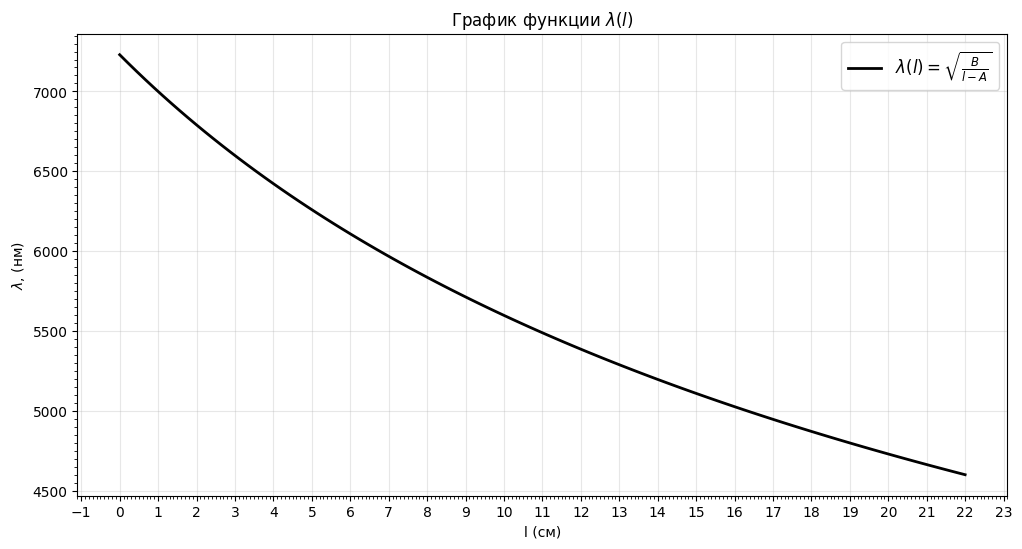

In [26]:
x = np.linspace(0, 22, 100)  # 100 точек от 0 до 22
lambdas: np.ndarray = l_to_lambda(centimeters)  # массив длин волн (нанометры)

_, ax = polt.subplots(1, 1, figsize=(12, 6))

ax.set_title("График функции $\\lambda(l)$")
ax.set_xlabel("l (см)")
ax.set_ylabel("$\\lambda$, (нм)")

ax.plot(
  x,
  l_to_lambda(x),
  "black",
  linewidth=2,
  label=r"$\lambda(l) = \sqrt{\frac{B}{l - A}}$",
)

# Точки:
# ax.scatter(
#   centimeters,
#   lambdas,
#   marker="o",
#   s=50,
#   linewidth=1.5,
#   color="black",
# )

# Производная:
# ax.plot(
#   x,
#   l_to_lambda_derived(x),
#   "red",
#   linewidth=2,
#   label=r"$\lambda(l)' = -\frac{1}{2} \frac{\lambda(l)}{l - A}$",
# )


ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

polt.grid(True, alpha=0.3)
polt.legend(fontsize=12)
polt.show()

**Спектральная плотность энергии излучения абсолютно чёрного тела (формула Планка):**
Используется для нормировки спектральной характеристики фотоэлемента, чтобы исключить зависимость от спектрального состава источника света (лампы накаливания).

$$
\Delta E(\lambda) = E_\lambda \Delta \lambda = \text{const} \cdot \frac{\lambda^{-5} \Delta \lambda}{\exp\left( \frac{hc}{\lambda k T} \right) - 1}
$$

где $T$ — температура нити лампы (указано 2880 K), $\Delta \lambda$ — ширина спектрального интервала.


In [27]:
def calculate_planck_spectrum():
  """Вычисляет спектральную плотность энергии по формуле Планка"""
  const = 1  # используем относительные значения

  lambda_m = lambdas * 1e-9  # переводим в метры
  exponent = (h * c) / (lambda_m * k * T)
  E_lambda = const * (lambda_m ** (-5)) / (np.exp(exponent) - 1)
  return E_lambda

**Нормированный фототок (спектральная характеристика):**
Характеристика, показывающая зависимость чувствительности фотоэлемента от длины волны, не зависящая от интенсивности падающего света.

$$
J_\lambda = \frac{J_\phi}{\Delta E(\lambda)}
$$

где $J_\phi$ — измеренный фототок.


In [28]:
delta_lambda = np.abs(l_to_lambda_derived(centimeters)) * l_cap  # нанометры

E_lambda = calculate_planck_spectrum()
delta_E = E_lambda * delta_lambda

J_lambda: dict[str, np.ndarray] = {
  SCV: experiment_spectral_data[SCV]["I"] / delta_E,
  CG: experiment_spectral_data[CG]["I"] / delta_E,
}

# Нормируем J_lambda на максимальное значение
J_lambda_norm: dict[str, np.ndarray] = {
  SCV: J_lambda[SCV] / np.max(J_lambda[SCV]),
  CG: J_lambda[CG] / np.max(J_lambda[CG]),
}

In [29]:
for photo_elem in (SCV, CG):
  table = Table(
    title=f"Спектральные характеристики фотоэлемента {photo_elem}",
    show_header=True,
    header_style="bold",
  )

  table.add_column("x, см", width=5)
  table.add_column("λ, нм", width=8)
  table.add_column("Δλ, нм", width=8)
  table.add_column("J_φ, мкА", width=5)
  table.add_column("E_λ (отн.)", width=12)
  table.add_column("ΔE(λ) (отн.)", width=12)
  # table.add_column("J_λ (отн.)", width=20)
  table.add_column("J_λ норм.", width=5)

  # Заполняем таблицу данными
  for i in range(len(centimeters)):
    table.add_row(
      f"{centimeters[i]}",
      f"{lambdas[i]:.2f}",
      f"{delta_lambda[i]:.2f}",
      f"{experiment_spectral_data[photo_elem]['I'][i]:.2f}",
      f"{E_lambda[i]:e}",
      f"{delta_E[i]:e}",
      # f"{J_lambda[photo_elem][i]:.2f}",
      f"{J_lambda_norm[photo_elem][i]:.2f}",
    )

  console.print(table)


               Спектральные характеристики фотоэлемента СЦВ-4                
┏━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┓
┃       ┃          ┃          ┃ J_φ,  ┃              ┃              ┃ J_λ   ┃
┃ x, см ┃ λ, нм    ┃ Δλ, нм   ┃ мкА   ┃ E_λ (отн.)   ┃ ΔE(λ) (отн.) ┃ норм. ┃
┡━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━┩
│ 0.0   │ 7229.94  │ 120.70   │ 0.77  │ 5.071702e+25 │ 6.121412e+27 │ 0.98  │
│ 1.0   │ 7000.00  │ 109.54   │ 0.59  │ 5.698871e+25 │ 6.242760e+27 │ 0.74  │
│ 2.0   │ 6790.69  │ 100.01   │ 0.40  │ 6.355745e+25 │ 6.356261e+27 │ 0.49  │
│ 3.0   │ 6599.10  │ 91.78    │ 0.28  │ 7.041479e+25 │ 6.462658e+27 │ 0.34  │
│ 4.0   │ 6422.86  │ 84.62    │ 0.22  │ 7.755268e+25 │ 6.562592e+27 │ 0.26  │
│ 5.0   │ 6260.02  │ 78.35    │ 0.18  │ 8.496341e+25 │ 6.656618e+27 │ 0.21  │
│ 6.0   │ 6108.98  │ 72.81    │ 0.17  │ 9.263959e+25 │ 6.745219e+27 │ 0.19  │
│ 7.0   │ 5968.36  │ 67.90    │ 0.14  │ 1.005741e+26 │ 6.828823e+27 │ 0.16  │
│ 8.0   │ 5837.03  │ 63.51    │ 0.12  │ 1.087602e+26 │ 6.907806e+27 │ 0.14  │
│ 9.0   │ 5714.01  │ 59.58    │ 0.13  │ 1.171913e+26 │ 6.982504e+27 │ 0.14  │
│ 10.0  │ 5598.45  │ 56.04    │ 0.12  │ 1.258610e+26 │ 7.053217e+27 │ 0.13  │
│ 11.0  │ 5489.62  │ 52.83    │ 0.11  │ 1.347634e+26 │ 7.120213e+27 │ 0.12  │
│ 12.0  │ 5386.91  │ 49.92    │ 0.12  │ 1.438923e+26 │ 7.183736e+27 │ 0.13  │
│ 13.0  │ 5289.75  │ 47.27    │ 0.12  │ 1.532423e+26 │ 7.244005e+27 │ 0.13  │
│ 14.0  │ 5197.67  │ 44.85    │ 0.10  │ 1.628078e+26 │ 7.301219e+27 │ 0.11  │
│ 15.0  │ 5110.24  │ 42.62    │ 0.11  │ 1.725834e+26 │ 7.355562e+27 │ 0.12  │
│ 16.0  │ 5027.07  │ 40.57    │ 0.12  │ 1.825640e+26 │ 7.407199e+27 │ 0.12  │
│ 17.0  │ 4947.84  │ 38.68    │ 0.10  │ 1.927445e+26 │ 7.456282e+27 │ 0.11  │
│ 18.0  │ 4872.24  │ 36.94    │ 0.11  │ 2.031202e+26 │ 7.502953e+27 │ 0.12  │
│ 19.0  │ 4800.00  │ 35.32    │ 0.10  │ 2.136862e+26 │ 7.547339e+27 │ 0.10  │
│ 20.0  │ 4730.88  │ 33.82    │ 0.10  │ 2.244381e+26 │ 7.589561e+27 │ 0.10  │
│ 21.0  │ 4664.67  │ 32.42    │ 0.10  │ 2.353713e+26 │ 7.629730e+27 │ 0.10  │
│ 22.0  │ 4601.16  │ 31.11    │ 0.10  │ 2.464815e+26 │ 7.667946e+27 │ 0.10  │
│ 21.5  │ 4632.59  │ 31.75    │ 0.10  │ 2.409045e+26 │ 7.649076e+27 │ 0.10  │
│ 20.5  │ 4697.43  │ 33.10    │ 0.12  │ 2.298823e+26 │ 7.609896e+27 │ 0.12  │
│ 19.5  │ 4765.07  │ 34.55    │ 0.11  │ 2.190392e+26 │ 7.568714e+27 │ 0.11  │
│ 18.5  │ 4835.71  │ 36.11    │ 0.10  │ 2.083797e+26 │ 7.525424e+27 │ 0.11  │
│ 17.5  │ 4909.60  │ 37.79    │ 0.12  │ 1.979083e+26 │ 7.479911e+27 │ 0.13  │
│ 16.5  │ 4986.98  │ 39.61    │ 0.11  │ 1.876296e+26 │ 7.432051e+27 │ 0.11  │
│ 15.5  │ 5068.14  │ 41.58    │ 0.11  │ 1.775484e+26 │ 7.381709e+27 │ 0.11  │
│ 14.5  │ 5153.40  │ 43.71    │ 0.13  │ 1.676696e+26 │ 7.328739e+27 │ 0.13  │
│ 13.5  │ 5243.11  │ 46.03    │ 0.11  │ 1.579985e+26 │ 7.272982e+27 │ 0.12  │
│ 12.5  │ 5337.67  │ 48.57    │ 0.11  │ 1.485401e+26 │ 7.214264e+27 │ 0.12  │
│ 11.5  │ 5437.54  │ 51.35    │ 0.13  │ 1.392999e+26 │ 7.152394e+27 │ 0.14  │
│ 10.5  │ 5543.23  │ 54.40    │ 0.12  │ 1.302835e+26 │ 7.087164e+27 │ 0.13  │
│ 9.5   │ 5655.34  │ 57.77    │ 0.12  │ 1.214967e+26 │ 7.018341e+27 │ 0.14  │
│ 8.5   │ 5774.54  │ 61.50    │ 0.13  │ 1.129455e+26 │ 6.945672e+27 │ 0.14  │
│ 7.5   │ 5901.60  │ 65.65    │ 0.14  │ 1.046361e+26 │ 6.868871e+27 │ 0.15  │
│ 6.5   │ 6037.44  │ 70.28    │ 0.15  │ 9.657499e+25 │ 6.787621e+27 │ 0.17  │
│ 5.5   │ 6183.12  │ 75.49    │ 0.17  │ 8.876876e+25 │ 6.701569e+27 │ 0.20  │
│ 4.5   │ 6339.87  │ 81.38    │ 0.20  │ 8.122441e+25 │ 6.610312e+27 │ 0.24  │
│ 3.5   │ 6509.19  │ 88.08    │ 0.26  │ 7.394916e+25 │ 6.513397e+27 │ 0.31  │
│ 2.5   │ 6692.84  │ 95.75    │ 0.35  │ 6.695056e+25 │ 6.410305e+27 │ 0.43  │
│ 1.5   │ 6892.96  │ 104.60   │ 0.49  │ 6.023649e+25 │ 6.300442e+27 │ 0.61  │
│ 0.5   │ 7112.18  │ 114.90   │ 0.70  │ 5.381519e+25 │ 6.183118e+27 │ 0.88  │
│ 0.0   │ 7229.94  │ 120.70   │ 0.79  │ 5.071702e+25 │ 6.121412e+27 │ 1.00  │
└───────┴──────────┴──

                Спектральные характеристики фотоэлемента ЦГ-4                
┏━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┓
┃       ┃          ┃          ┃ J_φ,  ┃              ┃              ┃ J_λ   ┃
┃ x, см ┃ λ, нм    ┃ Δλ, нм   ┃ мкА   ┃ E_λ (отн.)   ┃ ΔE(λ) (отн.) ┃ норм. ┃
┡━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━┩
│ 0.0   │ 7229.94  │ 120.70   │ 0.12  │ 5.071702e+25 │ 6.121412e+27 │ 0.39  │
│ 1.0   │ 7000.00  │ 109.54   │ 0.12  │ 5.698871e+25 │ 6.242760e+27 │ 0.39  │
│ 2.0   │ 6790.69  │ 100.01   │ 0.13  │ 6.355745e+25 │ 6.356261e+27 │ 0.40  │
│ 3.0   │ 6599.10  │ 91.78    │ 0.15  │ 7.041479e+25 │ 6.462658e+27 │ 0.47  │
│ 4.0   │ 6422.86  │ 84.62    │ 0.18  │ 7.755268e+25 │ 6.562592e+27 │ 0.55  │
│ 5.0   │ 6260.02  │ 78.35    │ 0.23  │ 8.496341e+25 │ 6.656618e+27 │ 0.69  │
│ 6.0   │ 6108.98  │ 72.81    │ 0.26  │ 9.263959e+25 │ 6.745219e+27 │ 0.78  │
│ 7.0   │ 5968.36  │ 67.90    │ 0.30  │ 1.005741e+26 │ 6.828823e+27 │ 0.89  │
│ 8.0   │ 5837.03  │ 63.51    │ 0.33  │ 1.087602e+26 │ 6.907806e+27 │ 0.95  │
│ 9.0   │ 5714.01  │ 59.58    │ 0.34  │ 1.171913e+26 │ 6.982504e+27 │ 1.00  │
│ 10.0  │ 5598.45  │ 56.04    │ 0.32  │ 1.258610e+26 │ 7.053217e+27 │ 0.92  │
│ 11.0  │ 5489.62  │ 52.83    │ 0.30  │ 1.347634e+26 │ 7.120213e+27 │ 0.87  │
│ 12.0  │ 5386.91  │ 49.92    │ 0.29  │ 1.438923e+26 │ 7.183736e+27 │ 0.83  │
│ 13.0  │ 5289.75  │ 47.27    │ 0.26  │ 1.532423e+26 │ 7.244005e+27 │ 0.72  │
│ 14.0  │ 5197.67  │ 44.85    │ 0.24  │ 1.628078e+26 │ 7.301219e+27 │ 0.68  │
│ 15.0  │ 5110.24  │ 42.62    │ 0.21  │ 1.725834e+26 │ 7.355562e+27 │ 0.59  │
│ 16.0  │ 5027.07  │ 40.57    │ 0.20  │ 1.825640e+26 │ 7.407199e+27 │ 0.54  │
│ 17.0  │ 4947.84  │ 38.68    │ 0.19  │ 1.927445e+26 │ 7.456282e+27 │ 0.52  │
│ 18.0  │ 4872.24  │ 36.94    │ 0.17  │ 2.031202e+26 │ 7.502953e+27 │ 0.47  │
│ 19.0  │ 4800.00  │ 35.32    │ 0.16  │ 2.136862e+26 │ 7.547339e+27 │ 0.42  │
│ 20.0  │ 4730.88  │ 33.82    │ 0.14  │ 2.244381e+26 │ 7.589561e+27 │ 0.39  │
│ 21.0  │ 4664.67  │ 32.42    │ 0.14  │ 2.353713e+26 │ 7.629730e+27 │ 0.37  │
│ 22.0  │ 4601.16  │ 31.11    │ 0.13  │ 2.464815e+26 │ 7.667946e+27 │ 0.34  │
│ 21.5  │ 4632.59  │ 31.75    │ 0.14  │ 2.409045e+26 │ 7.649076e+27 │ 0.36  │
│ 20.5  │ 4697.43  │ 33.10    │ 0.14  │ 2.298823e+26 │ 7.609896e+27 │ 0.38  │
│ 19.5  │ 4765.07  │ 34.55    │ 0.15  │ 2.190392e+26 │ 7.568714e+27 │ 0.42  │
│ 18.5  │ 4835.71  │ 36.11    │ 0.17  │ 2.083797e+26 │ 7.525424e+27 │ 0.45  │
│ 17.5  │ 4909.60  │ 37.79    │ 0.18  │ 1.979083e+26 │ 7.479911e+27 │ 0.49  │
│ 16.5  │ 4986.98  │ 39.61    │ 0.21  │ 1.876296e+26 │ 7.432051e+27 │ 0.57  │
│ 15.5  │ 5068.14  │ 41.58    │ 0.21  │ 1.775484e+26 │ 7.381709e+27 │ 0.59  │
│ 14.5  │ 5153.40  │ 43.71    │ 0.23  │ 1.676696e+26 │ 7.328739e+27 │ 0.64  │
│ 13.5  │ 5243.11  │ 46.03    │ 0.25  │ 1.579985e+26 │ 7.272982e+27 │ 0.70  │
│ 12.5  │ 5337.67  │ 48.57    │ 0.28  │ 1.485401e+26 │ 7.214264e+27 │ 0.77  │
│ 11.5  │ 5437.54  │ 51.35    │ 0.30  │ 1.392999e+26 │ 7.152394e+27 │ 0.85  │
│ 10.5  │ 5543.23  │ 54.40    │ 0.32  │ 1.302835e+26 │ 7.087164e+27 │ 0.92  │
│ 9.5   │ 5655.34  │ 57.77    │ 0.33  │ 1.214967e+26 │ 7.018341e+27 │ 0.96  │
│ 8.5   │ 5774.54  │ 61.50    │ 0.34  │ 1.129455e+26 │ 6.945672e+27 │ 0.98  │
│ 7.5   │ 5901.60  │ 65.65    │ 0.32  │ 1.046361e+26 │ 6.868871e+27 │ 0.94  │
│ 6.5   │ 6037.44  │ 70.28    │ 0.28  │ 9.657499e+25 │ 6.787621e+27 │ 0.83  │
│ 5.5   │ 6183.12  │ 75.49    │ 0.24  │ 8.876876e+25 │ 6.701569e+27 │ 0.73  │
│ 4.5   │ 6339.87  │ 81.38    │ 0.20  │ 8.122441e+25 │ 6.610312e+27 │ 0.61  │
│ 3.5   │ 6509.19  │ 88.08    │ 0.16  │ 7.394916e+25 │ 6.513397e+27 │ 0.51  │
│ 2.5   │ 6692.84  │ 95.75    │ 0.14  │ 6.695056e+25 │ 6.410305e+27 │ 0.45  │
│ 1.5   │ 6892.96  │ 104.60   │ 0.13  │ 6.023649e+25 │ 6.300442e+27 │ 0.42  │
│ 0.5   │ 7112.18  │ 114.90   │ 0.13  │ 5.381519e+25 │ 6.183118e+27 │ 0.44  │
│ 0.0   │ 7229.94  │ 120.70   │ 0.12  │ 5.071702e+25 │ 6.121412e+27 │ 0.39  │
└───────┴──────────┴──

In [30]:
sqrt_J_lambda: dict[str, np.ndarray] = {}
red_edge_data = {}

for photo_elem in (SCV, CG):
  # Создаем временные отсортированные массивы только для красной границы
  sort_idx = np.argsort(lambdas)
  sorted_lambdas = lambdas[sort_idx]
  sorted_J_lambda_norm = J_lambda_norm[photo_elem][sort_idx]

  sqrt_J_lambda[photo_elem] = np.sqrt(sorted_J_lambda_norm)

  console.print(
    "\n[bold cyan]Данные для построения графика √J_λ от λ "
    f"(вблизи красной границы для {photo_elem}):[/bold cyan]"
  )

  red_edge_table = Table(show_header=True, header_style="bold yellow")
  red_edge_table.add_column("λ, нм")
  red_edge_table.add_column("√J_λ")

  max_idx = np.argmax(sorted_J_lambda_norm)

  # Берем точки правее максимума
  red_edge_lambdas = sorted_lambdas[max_idx:]
  red_edge_sqrt_J = sqrt_J_lambda[photo_elem][max_idx:]

  for lam, sqrt_j in zip(red_edge_lambdas, red_edge_sqrt_J):
    red_edge_table.add_row(f"{lam:.1f}", f"{sqrt_j:.3f}")

  console.print(red_edge_table)

  console.print(
    f"\n[bold green]Максимум чувствительности при λ={sorted_lambdas[max_idx]:.1f} нм[/bold green]"
  )

  # Сохраняем отсортированные данные для последующего использования
  # (например, для построения графиков работы выхода)
  red_edge_data[photo_elem] = {
    "lambdas": red_edge_lambdas,
    "sqrt_J_lambda": red_edge_sqrt_J,
  }

Данные для построения графика √J_λ от λ (вблизи красной границы для СЦВ-4):

┏━━━━━━━━┳━━━━━━━┓
┃ λ, нм  ┃ √J_λ  ┃
┡━━━━━━━━╇━━━━━━━┩
│ 7229.9 │ 1.000 │
└────────┴───────┘

Максимум чувствительности при λ=7229.9 нм

Данные для построения графика √J_λ от λ (вблизи красной границы для ЦГ-4):

┏━━━━━━━━┳━━━━━━━┓
┃ λ, нм  ┃ √J_λ  ┃
┡━━━━━━━━╇━━━━━━━┩
│ 5714.0 │ 1.000 │
│ 5774.5 │ 0.989 │
│ 5837.0 │ 0.977 │
│ 5901.6 │ 0.971 │
│ 5968.4 │ 0.944 │
│ 6037.4 │ 0.913 │
│ 6109.0 │ 0.885 │
│ 6183.1 │ 0.853 │
│ 6260.0 │ 0.830 │
│ 6339.9 │ 0.784 │
│ 6422.9 │ 0.742 │
│ 6509.2 │ 0.713 │
│ 6599.1 │ 0.686 │
│ 6692.8 │ 0.668 │
│ 6790.7 │ 0.634 │
│ 6893.0 │ 0.647 │
│ 7000.0 │ 0.627 │
│ 7112.2 │ 0.663 │
│ 7229.9 │ 0.628 │
│ 7229.9 │ 0.628 │
└────────┴───────┘

Максимум чувствительности при λ=5714.0 нм

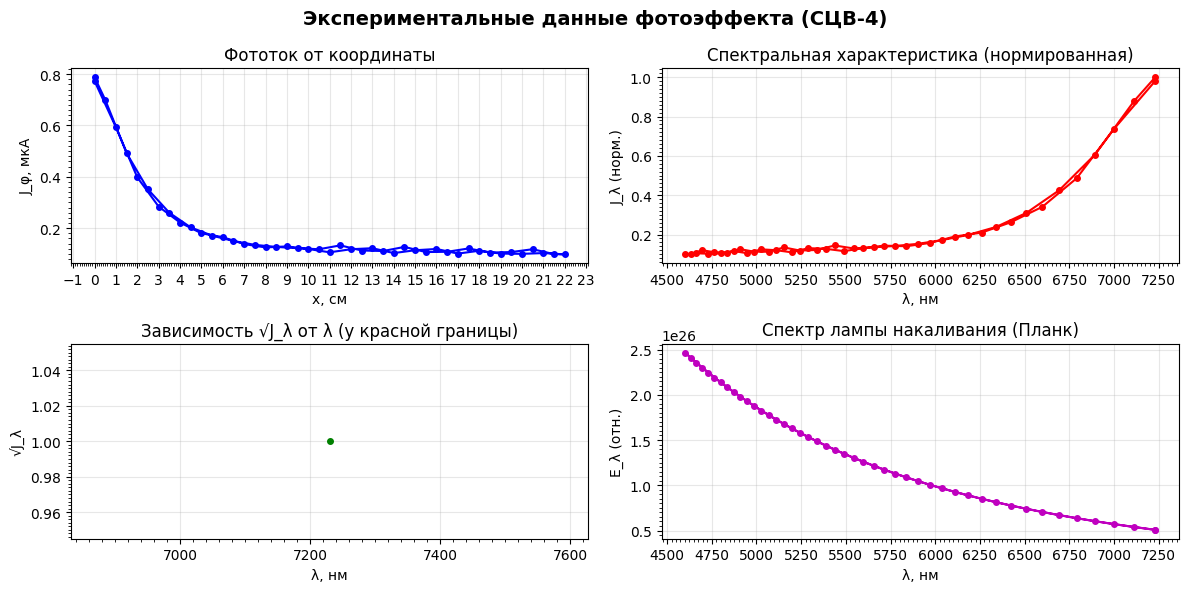

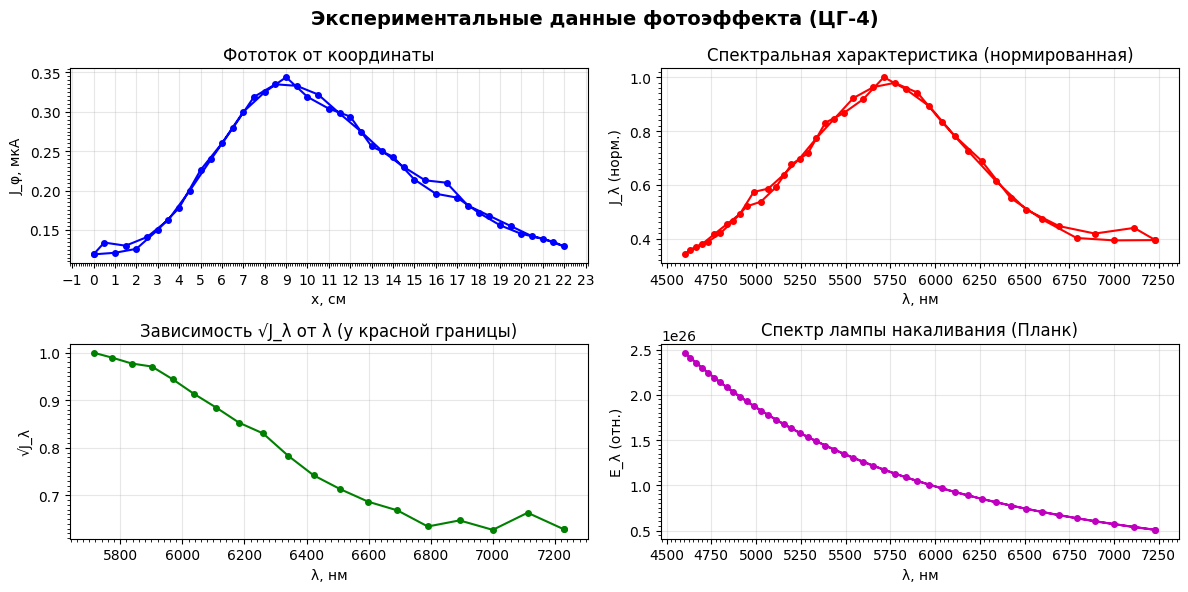

In [31]:
for photo_elem in (SCV, CG):
  # Сортируем данные для красной границы
  sort_idx = np.argsort(lambdas)
  sorted_lambdas = lambdas[sort_idx]
  sorted_J_lambda_norm = J_lambda_norm[photo_elem][sort_idx]
  sorted_sqrt_J_lambda = np.sqrt(sorted_J_lambda_norm)

  # Находим индекс максимума в отсортированном массиве
  max_idx_sorted = np.argmax(sorted_J_lambda_norm)

  fig, axes = polt.subplots(2, 2, figsize=(12, 6))
  fig.suptitle(
    f"Экспериментальные данные фотоэффекта ({photo_elem})", fontsize=14, fontweight="bold"
  )

  # Данные для графиков
  plots_data = [
    {
      "data": (
        experiment_spectral_data[photo_elem]["l"],
        experiment_spectral_data[photo_elem]["I"],
      ),
      "style": "bo-",
      "xlabel": "x, см",
      "ylabel": "J_φ, мкА",
      "title": "Фототок от координаты",
      "x_major": 1,
    },
    {
      "data": (lambdas, J_lambda_norm[photo_elem]),
      "style": "ro-",
      "xlabel": "λ, нм",
      "ylabel": "J_λ (норм.)",
      "title": "Спектральная характеристика (нормированная)",
      "x_major": 250,
    },
    {
      "data": (
        sorted_lambdas[max_idx_sorted:],
        sorted_sqrt_J_lambda[max_idx_sorted:],
      ),
      "style": "go-",
      "xlabel": "λ, нм",
      "ylabel": "√J_λ",
      "title": "Зависимость √J_λ от λ (у красной границы)",
      "x_major": 200,
    },
    {
      "data": (lambdas, E_lambda),
      "style": "mo-",
      "xlabel": "λ, нм",
      "ylabel": "E_λ (отн.)",
      "title": "Спектр лампы накаливания (Планк)",
      "x_major": 250,
    },
  ]

  # Создание графиков в цикле
  for i, (ax, plot_config) in enumerate(zip(axes.flat, plots_data)):
    x_data, y_data = plot_config["data"]
    ax.plot(x_data, y_data, plot_config["style"], markersize=4)
    ax.set_xlabel(plot_config["xlabel"])
    ax.set_ylabel(plot_config["ylabel"])
    ax.set_title(plot_config["title"])
    ax.grid(True, alpha=0.3)

    # Настройка сетки
    ax.xaxis.set_major_locator(MultipleLocator(plot_config["x_major"]))
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))

  polt.tight_layout()
  polt.show()

## Расчет работы выхода (примерный)

Находим линейную аппроксимацию для √J_λ вблизи красной границы


In [32]:
for photo_elem in (SCV, CG):
  # Берем последние 4 точки для аппроксимации
  lambda_red = lambdas[-4:]
  sqrt_J_red = sqrt_J_lambda[photo_elem][-4:]

  slope, intercept, r_value, p_value, std_err = stats.linregress(lambda_red, sqrt_J_red)

  # Красная граница - где √J_λ = 0
  lambda_critical = -intercept / slope
  work_function_ev = (h * c) / (lambda_critical * 1e-9 * 1.602e-19)  # перевод в эВ

  console.print(f"\n[bold green]РЕЗУЛЬТАТЫ ({photo_elem}):[/bold green]")
  console.print(f"Красная граница фотоэффекта: λ_кр = {lambda_critical:.1f} нм")
  console.print(f"Работа выхода: A = {work_function_ev:.2f} эВ")
  console.print(f"Коэффициент корреляции линейной аппроксимации: r = {r_value:.3f}")

РЕЗУЛЬТАТЫ (СЦВ-4):

Красная граница фотоэффекта: λ_кр = 3410.4 нм

Работа выхода: A = 0.36 эВ

Коэффициент корреляции линейной аппроксимации: r = 0.977

РЕЗУЛЬТАТЫ (ЦГ-4):

Красная граница фотоэффекта: λ_кр = 44899.3 нм

Работа выхода: A = 0.03 эВ

Коэффициент корреляции линейной аппроксимации: r = -0.226

## Развернутые ответы на контрольные вопросы:

### 1) Основные законы фотоэффекта и невозможность объяснения его с классической точки зрения

**Основные законы фотоэффекта (установлены экспериментально):**

1. **Закон Эйнштейна:** Кинетическая энергия фотоэлектронов линейно зависит от частоты падающего света и не зависит от его интенсивности:

   $$
   E_k = h\nu - A
   $$

   где $A$ - работа выхода материала.

2. **Существование красной границы:** Для каждого вещества существует минимальная частота $\nu_{min} = A/h$, ниже которой фотоэффект не наблюдается.

3. **Количество фотоэлектронов** пропорционально интенсивности света (числу фотонов).

4. **Фотоэффект безынерционен** - возникает мгновенно при освещении.

**Невозможность классического объяснения:**

- **Классическая теория:** Энергия электрона должна накапливаться постепенно, но фотоэффект возникает мгновенно
- **Необъяснимость красной границы:** По классике, при любой частоте, увеличивая интенсивность, можно было бы вырывать электроны
- **Независимость энергии от интенсивности:** По классике, энергия электронов должна зависеть от интенсивности света, а не от частоты

### 2) Другие эксперименты, в которых проявляются квантовые свойства излучения

1. **Фотоэлектрический эффект** - сам по себе доказывает квантовую природу света
2. **Эффект Комптона** - рассеяние рентгеновских лучей на электронах, демонстрирует корпускулярные свойства фотонов
3. **Опыты Франка и Герца** - демонстрация дискретных уровней энергии атомов
4. **Опыт Боте** - подтверждение корпускулярной природы света при рассеянии
5. **Атомные спектры** - дискретные спектральные линии свидетельствуют о квантовании энергии атомов

### 3) Основные закономерности равновесного излучения

**Законы Кирхгофа:** Отношение испускательной к поглощательной способности для всех тел одинаково и равно испускательной способности абсолютно черного тела:

$$
\frac{e(\nu,T)}{a(\nu,T)} = u(\nu,T)
$$

**Закон Планка:** Формула для спектральной плотности энергии излучения АЧТ:

$$
u(\nu,T) = \frac{8\pi h\nu^3}{c^3} \cdot \frac{1}{e^{h\nu/kT} - 1}
$$

**Закон смещения Вина:** Длина волны, соответствующая максимуму излучения:

$$
\lambda_{\text{max}} = \frac{b}{T}
$$

где $b$ — постоянная Вина, $T$ — абсолютная температура.

**Закон Рэлея-Джинса:** Классическая формула, справедливая только для малых частот:

$$
u(\nu,T) = \frac{8\pi\nu^2}{c^3}kT
$$

**Закон Стефана-Больцмана:** Полная энергетическая светимость АЧТ:

$$
R = \sigma T^4, \quad \sigma = 5.67\cdot10^{-8} \, \text{Вт/м}^2\text{К}^4
$$

### 4) Показать, что электронный газ в металле является «вырожденным»

**Критерий вырождения:** Газ считается вырожденным, когда длина волны де Бройля сравнима или больше среднего расстояния между частицами.

**Для электронов в металле:**

- Энергия Ферми: $E_F \approx 3-8$ эВ
- Температура Ферми: $T_F = E_F/k \approx 10^4-10^5$ К
- Длина волны де Бройля при $E_F$:
  $$
  \lambda = \frac{h}{p} = \frac{h}{\sqrt{2mE_F}} \approx 0.5-1 \, \text{нм}
  $$
- Среднее расстояние между электронами: $\approx 0.1-0.3$ нм

**Вывод:** $\lambda > d$, значит электронный газ вырожден даже при комнатной температуре ($T \ll T_F$).

### 5) Как влияют на фотоэффект температура и состояние поверхности фотокатода?

**Влияние температуры:**

- При повышении температуры увеличивается число электронов с энергией выше Ферми-уровня
- Уменьшается работа выхода
- Смещается красная граница в сторону больших длин волн
- Возможна термоэлектронная эмиссия при очень высоких температурах

**Влияние состояния поверхности:**

- Загрязнения поверхности увеличивают работу выхода
- Наличие оксидных пленок может как увеличивать, так и уменьшать работу выхода
- Шероховатость поверхности влияет на эффективность поглощения света
- Адсорбция атомов щелочных металлов уменьшает работу выхода

### 6) Оценить импульс, передаваемый решетке при поглощении электроном фотона вблизи красной границы

**Дано:** Красная граница для типичного металла $ A \approx 2 \, \text{эВ} $

**Импульс фотона вблизи красной границы:**

$$
p_{\text{фотона}} = \frac{h\nu}{c} \approx \frac{A}{c} = \frac{2 \cdot 1,6 \times 10^{-19} \, \text{Дж}}{3 \times 10^8 \, \text{м/с}} \approx 1,1 \times 10^{-27}
$$

**Импульс электрона с энергией Ферми** ($ E_F \approx 5 \, \text{эВ} $):

$$
p_e = \sqrt{2mE_F} = \sqrt{2 \cdot 9,1 \times 10^{-31} \, \text{кг} \cdot 5 \cdot 1,6 \times 10^{-19} \, \text{Дж}} \approx 1,2 \times 10^{-24}
$$

**Сравнение:**

$$
p_{\text{фотона}} \ll p_e
$$

$$
\frac{p_{\text{фотона}}}{p_e} \approx \frac{1,1 \times 10^{-27}}{1,2 \times 10^{-24}} \approx 0,001
$$

Решетка должна компенсировать разницу импульсов порядка $ 10^{-24} $ кг·м/с. Этот импульс передается всей кристаллической решетке, поэтому отдача практически незаметна.
